**<h1>Imports</h1>**


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import math
from math import sqrt

**<h1>Get Pictures</h1>**

In [2]:
imgs = []
imgs.append(cv2.imread('/content/drive/MyDrive/CV Sudoku Test Cases/01-Normal.jpg'))
imgs.append(cv2.imread('/content/drive/MyDrive/CV Sudoku Test Cases/02-TheMightyFinger.jpg'))
imgs.append(cv2.imread('/content/drive/MyDrive/CV Sudoku Test Cases/03-WhereBorder.jpg'))
imgs.append(cv2.imread('/content/drive/MyDrive/CV Sudoku Test Cases/04-CompressoEspresso.jpg'))
imgs.append(cv2.imread('/content/drive/MyDrive/CV Sudoku Test Cases/05-Ya3amSheel2elCoinYa3am.jpg'))
imgs.append(cv2.imread('/content/drive/MyDrive/CV Sudoku Test Cases/06-FarAndCurved.jpg'))
imgs.append(cv2.imread('/content/drive/MyDrive/CV Sudoku Test Cases/07-2elNoor2ata3.jpg'))
imgs.append(cv2.imread('/content/drive/MyDrive/CV Sudoku Test Cases/08-MeshShayef7agaYa3am.jpg'))
imgs.append(cv2.imread('/content/drive/MyDrive/CV Sudoku Test Cases/09-Normal2.jpg'))
imgs.append(cv2.imread('/content/drive/MyDrive/CV Sudoku Test Cases/10-Mal7wFelfel.jpg'))
imgs.append(cv2.imread('/content/drive/MyDrive/CV Sudoku Test Cases/11-FlashBang.jpg'))
imgs.append(cv2.imread('/content/drive/MyDrive/CV Sudoku Test Cases/12-BrokenPrinter.jpg'))
imgs.append(cv2.imread('/content/drive/MyDrive/CV Sudoku Test Cases/13-DarkMode.jpg'))
imgs.append(cv2.imread('/content/drive/MyDrive/CV Sudoku Test Cases/14-Sine.jpg'))
imgs.append(cv2.imread('/content/drive/MyDrive/CV Sudoku Test Cases/15-GoneWithTheWind.jpg'))
imgs.append(cv2.imread('/content/drive/MyDrive/CV Sudoku Test Cases/16-SomethingWentTerriblyWrongHere.jpg'))

# req = []
# req.append(urllib.request.urlopen('https://drive.google.com/drive/folders/1ni0bbYmBImN78rwR-zUZv7nh3gUxNmEO'))
# req.append(urllib.request.urlopen('https://sources.roboflow.com/dcbM99GUgvVCEMo4F2rq8vaVApB2/DSJGI2e7g77XqctWIGQG/original.jpg'))
# req.append(urllib.request.urlopen('https://live.staticflickr.com/8027/6978422072_33ac92fe1a_b.jpg'))
# req.append(urllib.request.urlopen('https://sources.roboflow.com/dcbM99GUgvVCEMo4F2rq8vaVApB2/cXodOMB4zutSooOqjqj0/original.jpg'))
NUM_IMAGES = 16
NUM_ROWS_PLOT = 4
NUM_COLS_PLOT = 4

# for i in range(0,NUM_IMAGES):
#   arr = np.asarray(bytearray(req[i].read()), dtype=np.uint8)
#   imgs.append(cv2.imdecode(arr, -1)) # 'Load it as it is'


# plt.imshow(imgs[4])


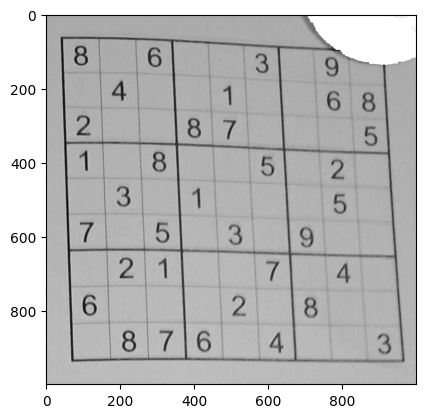

In [3]:
# REMOVE YELLOW COIN FROM IMAGES
lowerValues = np.array([10, 50, 70])
upperValues = np.array([35, 255, 255])
imgsWithoutCoins = []
imgIndexsWithCoins = []
for i in range(0, NUM_IMAGES):
    grayscaleImage = cv2.cvtColor(imgs[i], cv2.COLOR_BGR2GRAY)
    hsvImage = cv2.cvtColor(imgs[i], cv2.COLOR_BGR2HSV)
    coinMask = cv2.inRange(hsvImage, lowerValues, upperValues)

    # Increase the size of the mask using dilation
    dilateKernel = np.ones((15, 15), np.uint8)
    coinMask = cv2.dilate(coinMask, dilateKernel, iterations=1)

    morphKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    coinMask = cv2.morphologyEx(coinMask, cv2.MORPH_CLOSE, morphKernel, None, None, 1, cv2.BORDER_REFLECT101)

    if cv2.countNonZero(coinMask) > 30000:
        imgIndexsWithCoins.append(i)
        imgWithoutCoins = cv2.add(grayscaleImage, coinMask)
    else:
        # If the coin mask is smaller than the threshold, use the original grayscale image
        imgWithoutCoins = grayscaleImage

    imgsWithoutCoins.append(imgWithoutCoins)

plt.imshow(imgsWithoutCoins[4], cmap='gray')
plt.show()

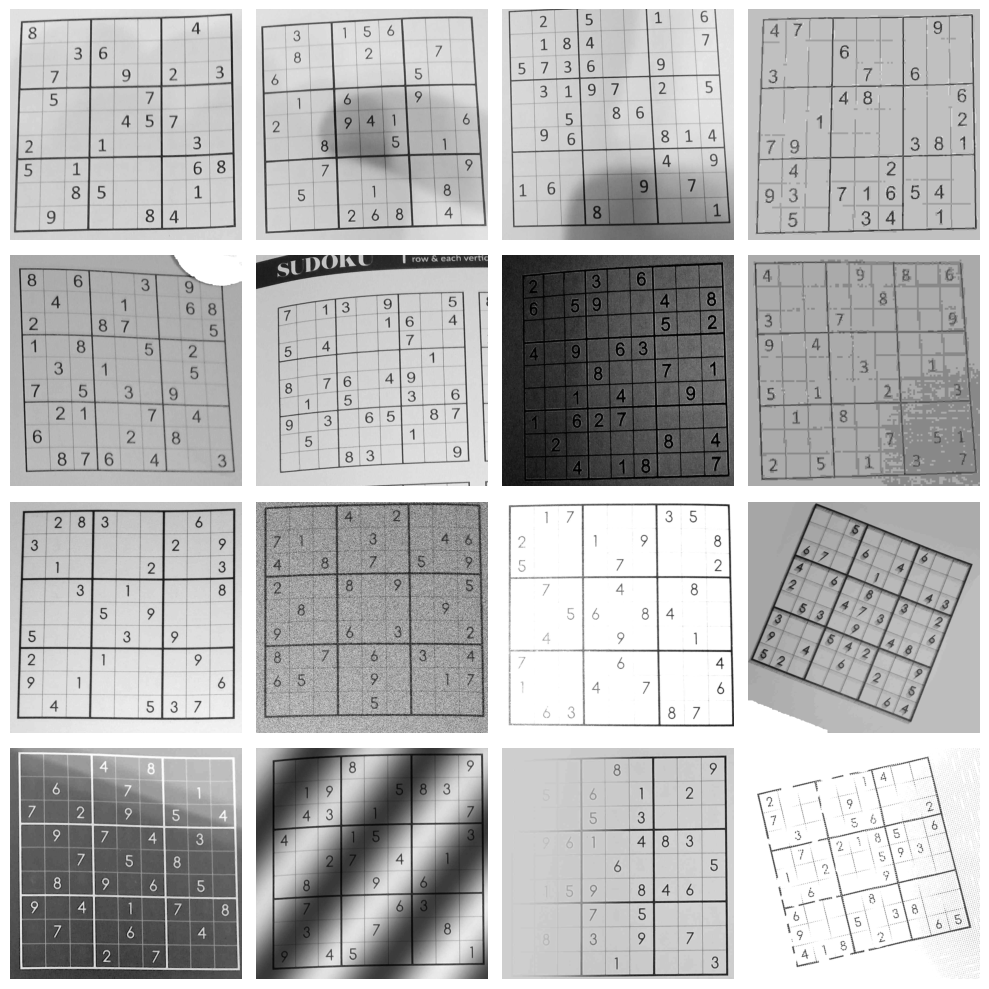

In [4]:
grayImgs = []
zeroImgs = []
for i in range(0,NUM_IMAGES):
  # padded_image = cv2.copyMakeBorder(img, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

  if len(imgsWithoutCoins[i].shape) == 2:  # Single-channel image
      grayImgs.append(imgsWithoutCoins[i])
  else:  # Multi-channel image, convert to grayscale
      grayImgs.append(cv2.cvtColor(imgsWithoutCoins[i], cv2.COLOR_BGR2GRAY))
  # if i == 12: # ADJUST THAT
  #     grayImgs[i] = cv2.bitwise_not(grayImgs[i])

  zeroImgs.append(np.zeros((grayImgs[i].shape),np.uint8))

# plt.imshow(grayImg, cmap = 'gray')




fig, axes = plt.subplots(NUM_ROWS_PLOT, NUM_COLS_PLOT, figsize=(10, 10))
axes = axes.flatten()
for i in range(NUM_IMAGES):
    if i < NUM_IMAGES:
        axes[i].imshow(grayImgs[i], cmap='gray')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

**<h1>Remove Periodic Noise Using Fourier Transform</h1>**

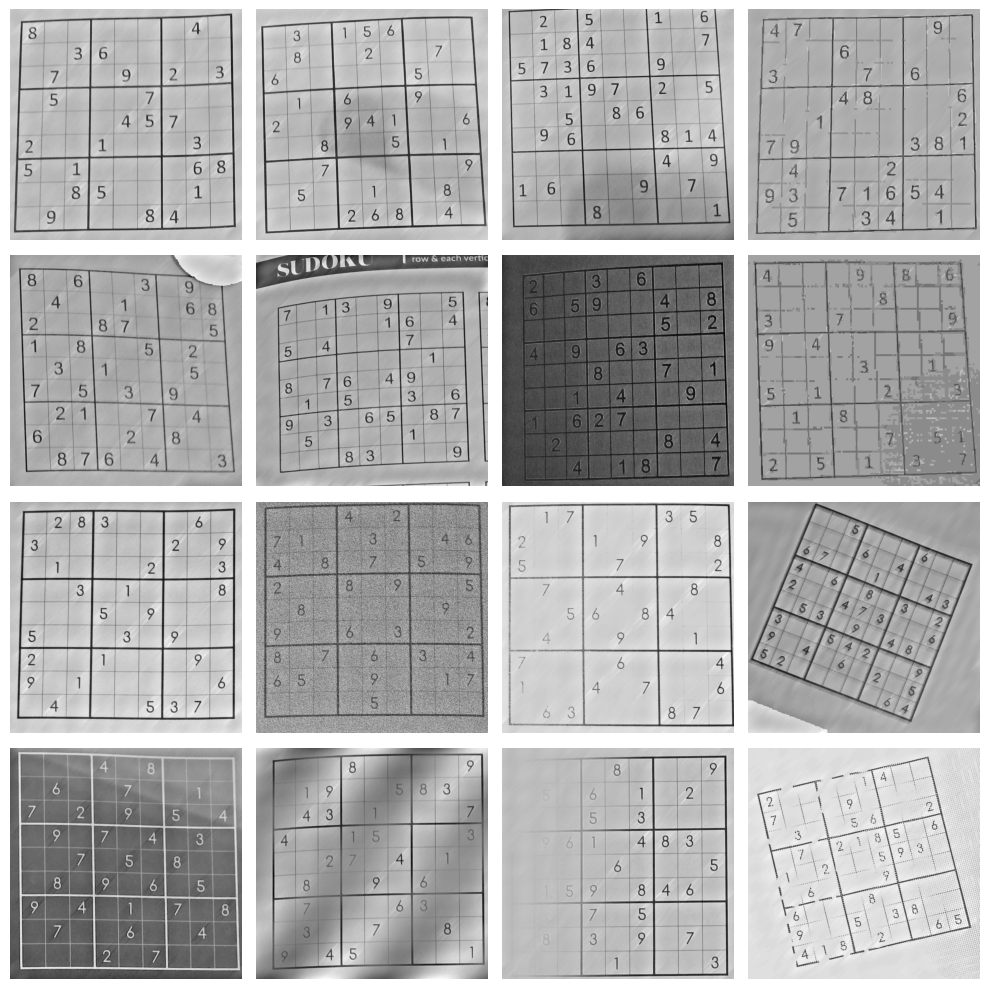

In [5]:
# THIS STEP IS DONE ONLY FOR IMPROVING NUMBERS IN CELLS NOT FOR GETTING THE CONTOUR
def distance(point1, point2):
    return sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


def butterworthLP(D0, imgShape, n):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows / 2, cols / 2)
    for x in range(cols):
        for y in range(rows):
            base[y, x] = 1 / (1 + (distance((y, x), center) / D0) ** (2 * n))
    return base

frequencyFilteredImgs = []
for imgNum in range(0,NUM_IMAGES):
    fourier_transform = np.fft.fft2(grayImgs[imgNum])
    center_shift = np.fft.fftshift(fourier_transform)

    fourier_noisy = 20 * np.log(np.abs(center_shift))

    rows, cols = grayImgs[imgNum].shape
    crow, ccol = rows // 2, cols // 2

    for x in range(0, rows):
      for y in range(0, cols):
        if (x == y):
          for i in range(0, 10):
            center_shift[x - i, y] = 1


    filtered = center_shift * butterworthLP(80, grayImgs[imgNum].shape, 10)

    f_shift = np.fft.ifftshift(center_shift)
    denoised_image = np.fft.ifft2(f_shift)
    frequencyFilteredImgs.append(np.real(denoised_image))

    # f_ishift_blpf = np.fft.ifftshift(filtered)
    # denoised_image_blpf = np.fft.ifft2(f_ishift_blpf)
    # frequencyFilteredImgs.append(np.real(denoised_image_blpf))
min_value = np.min([np.min(array) for array in frequencyFilteredImgs])
max_value = np.max([np.max(array) for array in frequencyFilteredImgs])

# Scale and convert each array to uint8
frequencyFilteredImgs = [(array - min_value) / (max_value - min_value) * 255 for array in frequencyFilteredImgs]
frequencyFilteredImgs = [np.round(scaled_array).astype(np.uint8) for scaled_array in frequencyFilteredImgs]


fig, axes = plt.subplots(NUM_ROWS_PLOT, NUM_COLS_PLOT, figsize=(10, 10))
axes = axes.flatten()
for i in range(NUM_IMAGES):
    if i < NUM_IMAGES:
        axes[i].imshow(frequencyFilteredImgs[i], cmap='gray')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

**<h1>Preprocessing</h1>**

<ipython-input-6-ebb7b89ade2b>:25: RuntimeWarning: invalid value encountered in divide
  div = np.float32(threshImgs[i])/(close)


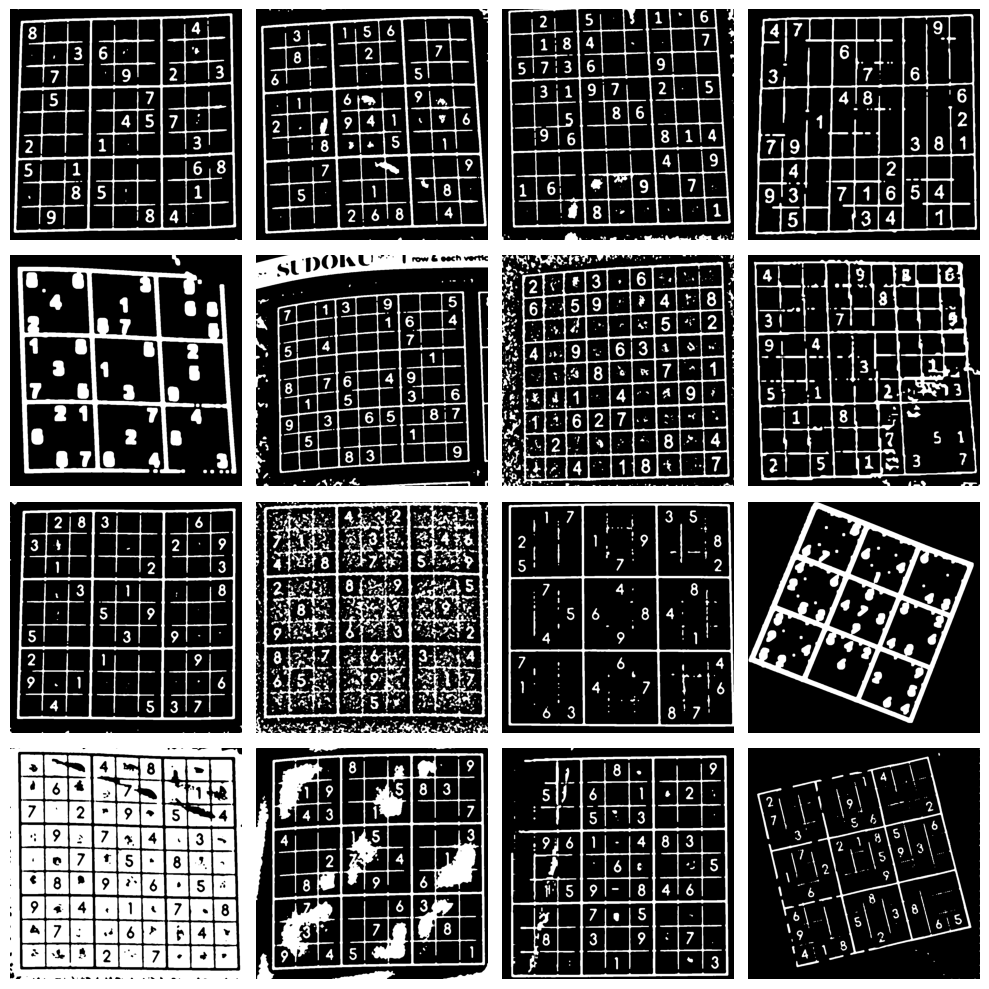

In [6]:
blurImgs = []
threshImgs = []
for i in range(NUM_IMAGES):
  blurImgs.append(cv2.GaussianBlur(grayImgs[i],(5,5),0))
  if i in imgIndexsWithCoins:
      _, thresh_img = cv2.threshold(blurImgs[i], 125, 255, cv2.THRESH_BINARY_INV)
      kernel2 = np.ones((15, 15), np.uint8)
      threshImgs.append(cv2.dilate(thresh_img, kernel2, iterations=1))
  else:
      threshImgs.append(cv2.adaptiveThreshold(blurImgs[i],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,131,1))

  threshImgs[i] = cv2.medianBlur(threshImgs[i], 9)

  # threshImgs[i] = cv2.copyMakeBorder(threshImgs[i], 50, 50, 50, 50, cv2.BORDER_CONSTANT, (0, 0, 0))

# threshImg = cv2.adaptiveThreshold(blurImg,255,0,1,19,2)


#plt.imshow(threshImg, cmap = 'gray')

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
closedImgs = []
for i in range(NUM_IMAGES):
  close = cv2.morphologyEx(threshImgs[i], cv2.MORPH_CLOSE, kernel)
  div = np.float32(threshImgs[i])/(close)
  closedImgs.append(np.uint8(cv2.normalize(div,div,0,255,cv2.NORM_MINMAX)))
# closed_image = cv2.cvtColor(closed_image_1,cv2.COLOR_RGB2BGR)
# plt.imshow(closed_image, cmap="gray")

fig, axes = plt.subplots(NUM_ROWS_PLOT, NUM_COLS_PLOT, figsize=(10, 10))
axes = axes.flatten()
for i in range(NUM_IMAGES):
    if i < NUM_IMAGES:
        axes[i].imshow(closedImgs[i], cmap='gray')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

**<h1>Invert Image if the white pixels number is too big</h1>**

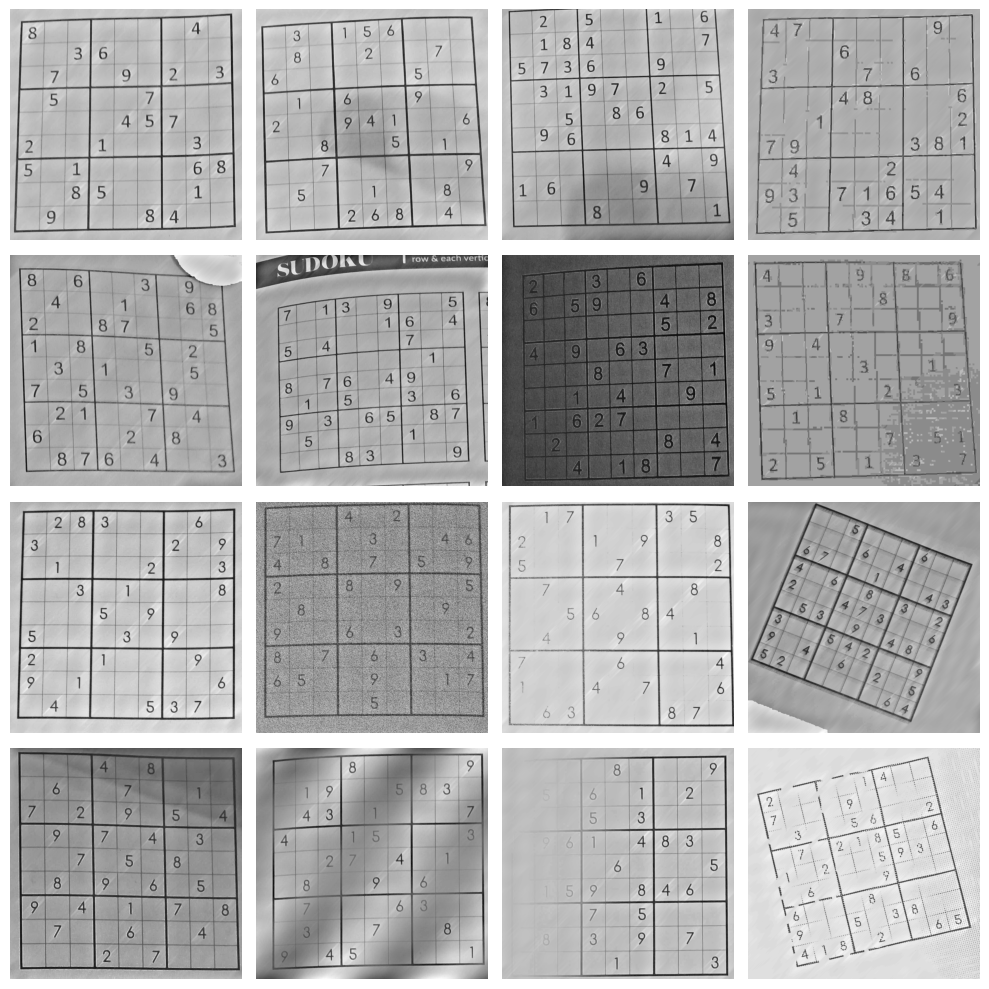

In [7]:
# Invert pixels if dark pixels is more than white
for i in range(0,NUM_IMAGES):
    _, binary_mask = cv2.threshold(closedImgs[i], 128, 255, cv2.THRESH_BINARY)

    # Count the number of white and black pixels in the binary mask
    num_white_pixels = np.sum(binary_mask == 255)
    num_black_pixels = np.sum(binary_mask == 0)
    # Check if dark pixels are more than white pixels
    if num_black_pixels < num_white_pixels:
        closedImgs[i] = cv2.bitwise_not(closedImgs[i])
        frequencyFilteredImgs[i] = cv2.bitwise_not(frequencyFilteredImgs[i])

fig, axes = plt.subplots(NUM_ROWS_PLOT, NUM_COLS_PLOT, figsize=(10, 10))
axes = axes.flatten()
for i in range(NUM_IMAGES):
    if i < NUM_IMAGES:
        axes[i].imshow(frequencyFilteredImgs[i], cmap='gray')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

**<h1>Contours</h1>**


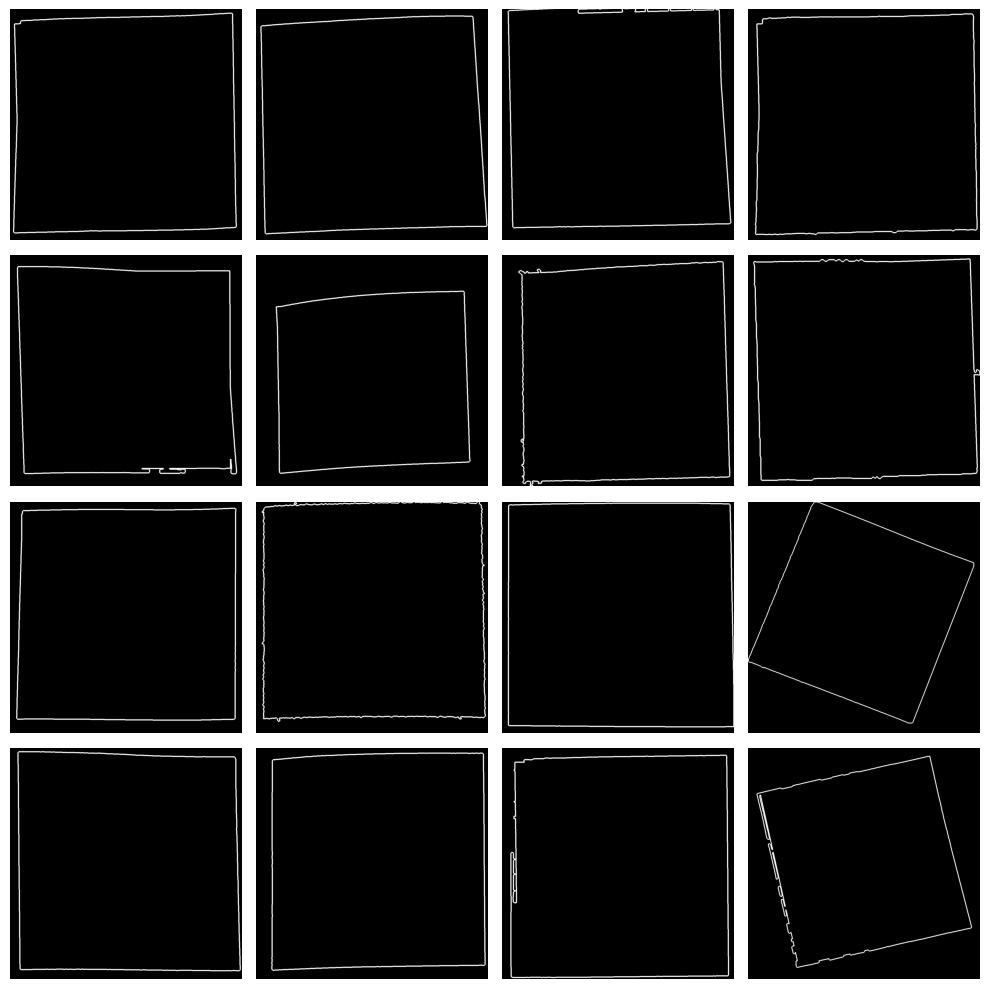

In [43]:
contourImgs = []
bestCnts = []
finalContourImgs = []
finalBestCnts = []
rotatedRects = []

for i in range(NUM_IMAGES):
    contourImgs.append(np.zeros((closedImgs[i].shape), np.uint8))
    contour, hier = cv2.findContours(closedImgs[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    max_area = 0
    bestCnts.append(None)

    for cnt in contour:
        area = cv2.contourArea(cnt)
        if area > max_area:
            max_area = area
            bestCnts[i] = cnt
        cv2.drawContours(contourImgs[i], [cnt], 0, 255, 2)

    if max_area < 400000:
      # Do some operations before getting contour as there are probably gaps in the image
      median = cv2.medianBlur(grayImgs[i], 9)
      cannyImg = cv2.Canny(median, 50, 150)
      kernel2 = np.ones((15, 15), np.uint8)
      dilated_edges = cv2.dilate(cannyImg, kernel2, iterations=4)
      eroded_edges = cv2.erode(dilated_edges, kernel2, iterations=2)
      contour, hier = cv2.findContours(eroded_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      # bestCnts[i] = cv2.convexHull(contour[0])
      max_area = 0
      for cnt in contour:
          area = cv2.contourArea(cnt)
          if area > max_area:
              max_area = area
              bestCnts[i] = cnt

    # Store rotated rectangle in the array
    if bestCnts[i] is not None:
        epsilon = 0.01 * cv2.arcLength(bestCnts[i], True)
        approx = cv2.approxPolyDP(bestCnts[i], epsilon, True)

        rotated_rect = cv2.minAreaRect(approx)
        rect_center, rect_size, rect_angle = rotated_rect
        rect_size = (rect_size[0] - 2 * 20, rect_size[1] - 2 * 28)
        #rect_center = (rect_center[0] - 10, rect_center[1] + 5)
        rect_size = (rect_size[0], rect_size[1] + 5)
        rotated_rect = (rect_center, rect_size, rect_angle)
        rotatedRects.append(rotated_rect)

    # Draw rotated rectangle
    if bestCnts[i] is not None:
        box = np.int0(cv2.boxPoints(rotated_rect))
        cv2.drawContours(contourImgs[i], [box], 0, 255, 2)
        finalContourImgs.append(np.zeros((closedImgs[i].shape), np.uint8))
        contourFinal, hierFinal = cv2.findContours(contourImgs[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        max_areaFinal = 0
        finalBestCnts.append(None)

        for cnt2 in contourFinal:
            areaFinal = cv2.contourArea(cnt2)
            if areaFinal > max_areaFinal:
                max_areaFinal = areaFinal
                finalBestCnts[i] = cnt2
        cv2.drawContours(finalContourImgs[i],[finalBestCnts[i]],0,255,3)



fig, axes = plt.subplots(NUM_ROWS_PLOT, NUM_COLS_PLOT, figsize=(10, 10))
axes = axes.flatten()
for i in range(NUM_IMAGES):
    if i < NUM_IMAGES:
        axes[i].imshow(finalContourImgs[i], cmap='gray')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

# plt.imshow(contourImg, cmap='gray')

**<h1>Prepare For Prespective Transform</h1>**

In [44]:
def sortPoints(points):
  points = points.reshape((4,2))
  pointsSorted = np.zeros((4,1,2), dtype = np.int32)
  addPoints = points.sum(1)
  pointsSorted[0] = points[np.argmin(addPoints)]
  pointsSorted[3] = points[np.argmax(addPoints)]
  diffPoints = np.diff(points, axis=1)
  pointsSorted[1] = points[np.argmin(diffPoints)]
  pointsSorted[2] = points[np.argmax(diffPoints)]
  return pointsSorted

In [45]:
pts1 = []
pts2 = []
for i in range(NUM_IMAGES):
  arcLength = cv2.arcLength(finalBestCnts[i],True)
  approx = cv2.approxPolyDP(finalBestCnts[i],0.02*arcLength,True)
  try:
    approxNew = sortPoints(approx)

    width,height = 450,450

    pts1.append(np.float32(approxNew))
    pts2.append(np.float32([[0,0], [width,0], [0,height], [width,height]]))
  except:
    pts1.append(0)
    pts2.append(0)

**<h1>Presepctive Transform</h1>**

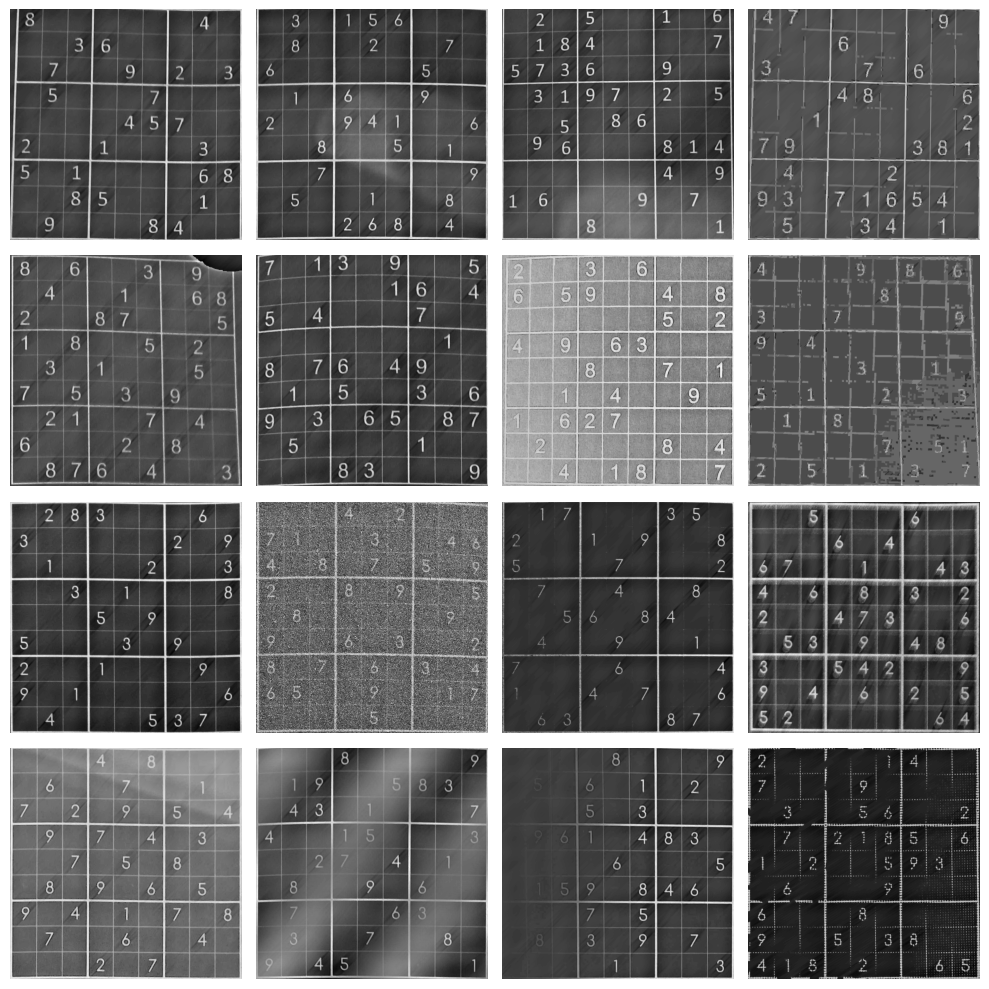

In [46]:
perspectiveImgs = []
for i in range(NUM_IMAGES):
  try:
    invertedImg = cv2.bitwise_not(frequencyFilteredImgs[i])
    matrix = cv2.getPerspectiveTransform(pts1[i],pts2[i])
    perspectiveImgs.append(cv2.warpPerspective(invertedImg,matrix,(width,height)))
  except:
    perspectiveImgs.append(0)
# finalImg = cv2.cvtColor(img_perspective, cv2.COLOR_BGR2GRAY)
# plt.imshow(img_perspective, cmap='gray')
fig, axes = plt.subplots(NUM_ROWS_PLOT, NUM_COLS_PLOT, figsize=(10, 10))
axes = axes.flatten()
for i in range(NUM_IMAGES):
    try:
      if i < NUM_IMAGES:
          axes[i].imshow(perspectiveImgs[i], cmap='gray')
          axes[i].axis('off')
    except:
      pass
plt.tight_layout()
plt.show()

**<h1>Seperate the Number Tiles</h1>**


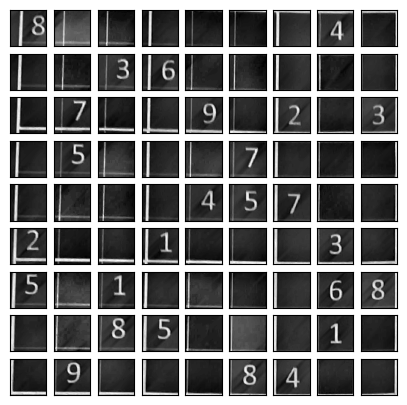

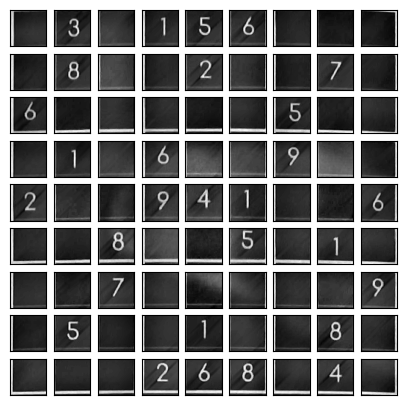

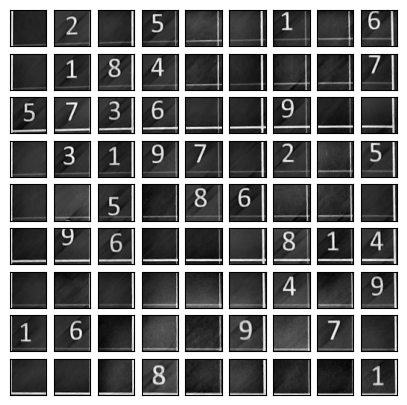

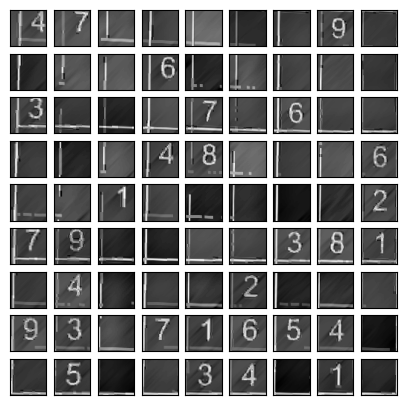

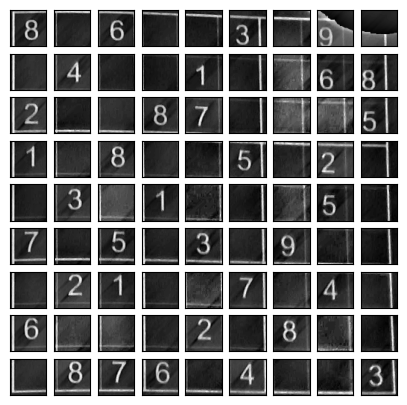

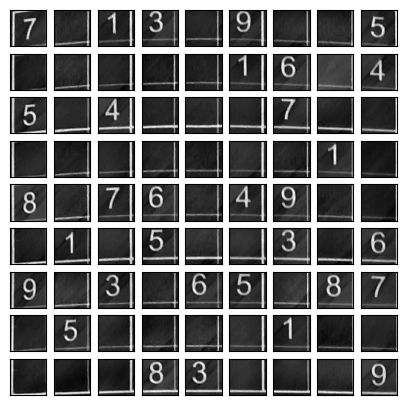

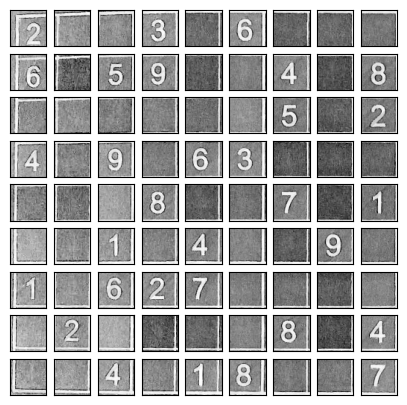

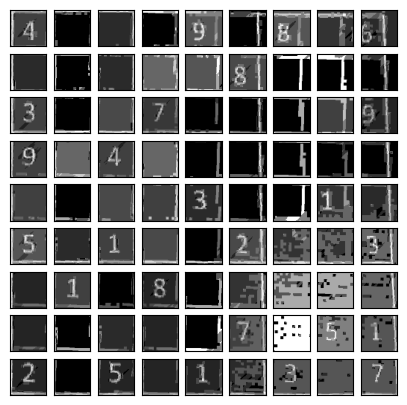

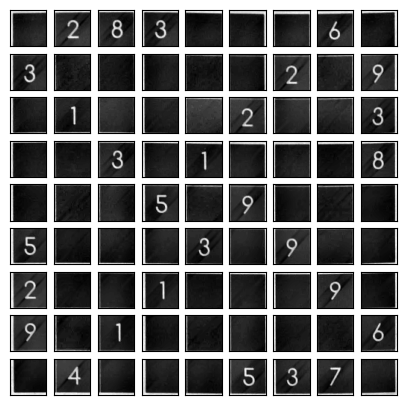

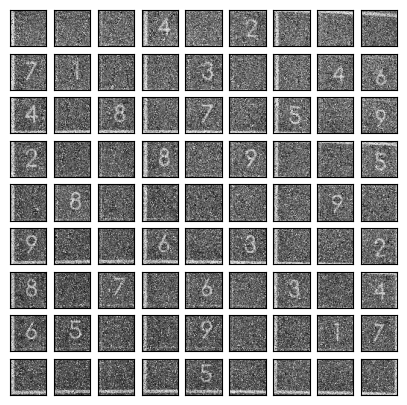

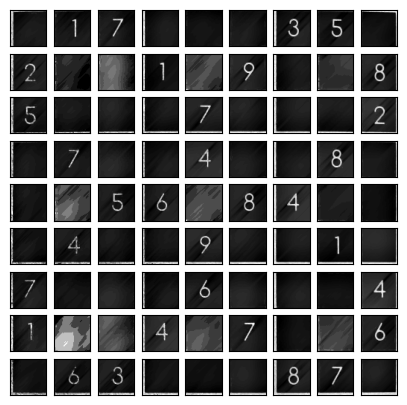

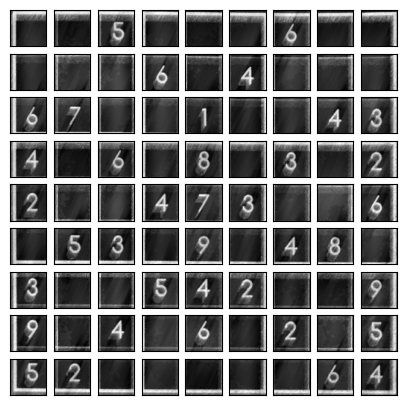

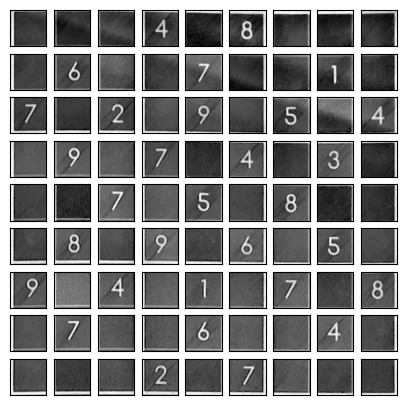

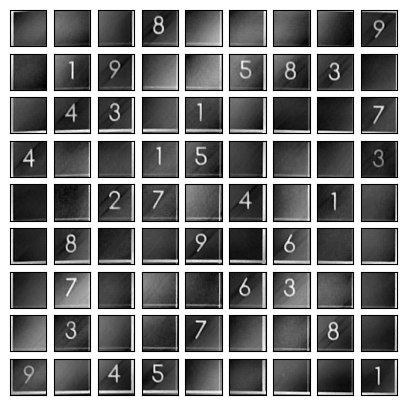

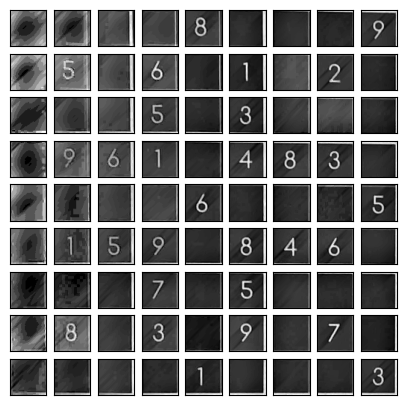

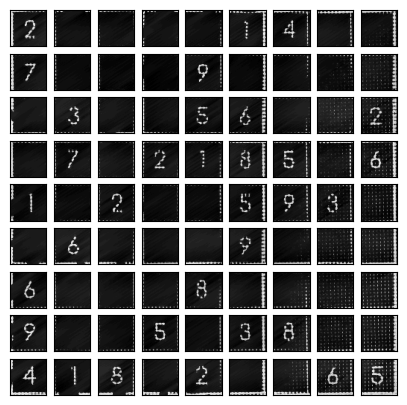

In [47]:
number_tiles = []
for x in range(NUM_IMAGES):
  try:
    number_tiles.append([])
    M = perspectiveImgs[x].shape[0] // 9
    N = perspectiveImgs[x].shape[1] // 9
    for i in range(9):
        number_tiles[x].append([])
        for j in range(9):
            tile = perspectiveImgs[x][i*M:(i+1)*M, j*N:(j+1)*N]
            number_tiles[x][i].append(tile)

    _, axes = plt.subplots(9, 9, figsize=(5, 5))
    for i, row in enumerate(axes):
        for j, col in enumerate(row):
            col.imshow(number_tiles[x][i][j], cmap="gray");
            col.get_xaxis().set_visible(False)
            col.get_yaxis().set_visible(False)
  except:
    pass
